In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import math
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
players_teams = pd.read_csv("/content/drive/Shareddrives/ML 2024/dataset/players_teams.csv")
players_teams.designation = 'players_teams'

players_teams_11 = pd.read_csv("/content/drive/Shareddrives/ML 2024/dataset/Season_11/players_teams.csv")
players_teams_11.designation = 'players_teams_11'

players = pd.read_csv("/content/drive/Shareddrives/ML 2024/dataset/players.csv")
players.designation = 'players'

teams = pd.read_csv("/content/drive/Shareddrives/ML 2024/dataset/teams.csv")
teams.designation = 'teams'

teams_11 = pd.read_csv("/content/drive/Shareddrives/ML 2024/dataset/Season_11/teams.csv")
teams_11.designation = 'teams_11'

players_teams = pd.concat([players_teams,players_teams_11], ignore_index=True)
teams = pd.concat([teams,teams_11], ignore_index=True)

## Data understanding, feature extraction and cleaning data from the players_teams and players table.

In the next steps of the project we will add players features to the main table obtained in the Model Exploration notebook.

For now, we will clean and add new features to the table players_teams. Eventually, but not in this notebook, we will add a table derived from players_teams to the main table.

As some teams change tmID from one year to another, lets add franchID to players table

In [ ]:
players_teams = players_teams.merge(teams[['tmID', 'year', 'franchID']], on=['tmID', 'year'], how='left')
players_teams.head()

,playerID,year,stint,tmID,lgID,GP,GS,minutes,points,oRebounds,...,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ,franchID
0,abrossv01w,2,0,MIN,WNBA,26.0,23.0,846.0,343.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIN
1,abrossv01w,3,0,MIN,WNBA,27.0,27.0,805.0,314.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIN
2,abrossv01w,4,0,MIN,WNBA,30.0,25.0,792.0,318.0,44.0,...,8.0,8.0,22.0,6.0,8.0,8.0,7.0,3.0,0.0,MIN
3,abrossv01w,5,0,MIN,WNBA,22.0,11.0,462.0,146.0,17.0,...,3.0,7.0,23.0,8.0,4.0,2.0,8.0,2.0,0.0,MIN
4,abrossv01w,6,0,MIN,WNBA,31.0,31.0,777.0,304.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIN


Lets add 'pos' and 'height' from the player table to players_teams.

In [ ]:
players = players.rename(columns={'bioID': 'playerID'})

players_teams = players_teams.merge(players[['playerID', 'pos', 'height']], on='playerID', how='left')
players_teams.head()

,playerID,year,stint,tmID,lgID,GP,GS,minutes,points,oRebounds,...,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ,franchID,pos,height
0,abrossv01w,2,0,MIN,WNBA,26.0,23.0,846.0,343.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIN,F,74.0
1,abrossv01w,3,0,MIN,WNBA,27.0,27.0,805.0,314.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIN,F,74.0
2,abrossv01w,4,0,MIN,WNBA,30.0,25.0,792.0,318.0,44.0,...,22.0,6.0,8.0,8.0,7.0,3.0,0.0,MIN,F,74.0
3,abrossv01w,5,0,MIN,WNBA,22.0,11.0,462.0,146.0,17.0,...,23.0,8.0,4.0,2.0,8.0,2.0,0.0,MIN,F,74.0
4,abrossv01w,6,0,MIN,WNBA,31.0,31.0,777.0,304.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIN,F,74.0


As coaches have been added to the players table with a position of NaN, so lets remove players where 'pos' is null

In [ ]:
players_teams = players_teams.dropna(subset=['pos'])

Players in the year 11 don't have statistics, so naturally there will be a lot of NaN for those players. Now lets see if for the other years there are NaN values.

In [ ]:
players_without_11 = players_teams[players_teams['year'] < 11]

for col in players_teams.columns:
    if players_without_11[col].dtype in ['float64', 'int64']:
        na_num = players_without_11[col].isna().sum()
        if na_num > 0:
            print(f"Column '{col}' has {na_num} NaN values.")

It seems there are no NaN values for the other years.

Lets remove 'lgID' because it is the same for every player.

In [ ]:
del players_teams['lgID']

Lets try to find outliers using boxplots. For most statistics is difficult to say if a value is really absurrd or not. So lets just analize 'minutes', 'height' and 'PostMinutes'.

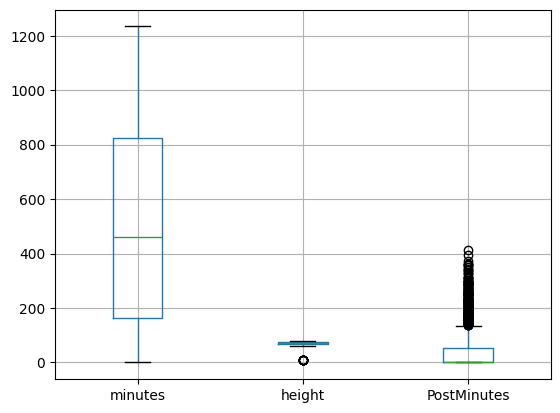

In [ ]:
players_teams.boxplot(column=['minutes', 'height', 'PostMinutes'])
plt.show()

Using the box plots above, it seems that the column 'minutes' has no outliers, and 'PostMinutes' has so many values outside the quantiles, that we don't know which are outliers or not. As of 'height' there are some values that seem off.

In [ ]:
Q1 = players_teams['height'].quantile(0.25)
Q3 = players_teams['height'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = players_teams[(players_teams['height'] < lower_bound) | (players_teams['height'] > upper_bound)]
print(outliers[['playerID', 'height']])

       playerID  height
417  dydekma01w     9.0
418  dydekma01w     9.0
419  dydekma01w     9.0
420  dydekma01w     9.0
421  dydekma01w     9.0
422  dydekma01w     9.0
423  dydekma01w     9.0
424  dydekma01w     9.0
425  dydekma01w     9.0


Height of every player is in inches, but in the case of 'dydekma01w', the dataset says that it has 9 inches in height (22.86 cm), which is impossible.
Someone might assume it was a typing mistake, and it is not 9 inches but 9 feet, which is equivalent to 274cm, which is also not reasonable.

Using outside sources, namely [Basketball Reference](https://www.basketball-reference.com/wnba/players/d/dydekma01w.html), we discovered that this player's heigh is 86 inches(218cm), so lets replace the height with that

In [ ]:
players_teams.loc[players_teams['playerID'] == 'dydekma01w', 'height'] = 86

We can see some players have 0 minutes played.

So lets see if there are any players with 0 minutes, but with Games Played ('GP') higher than one, which in reality is not posible

In [ ]:
players_teams[(players_teams['minutes'] == 0) & (players_teams['GP'] > 1)]

,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ,franchID,pos,height


The players_teams table has a lot of features, so lets see which are correlated using the Pearson Correlation Coefficient

In [ ]:
def check_correlations(table):
  corr_table = table.copy()

  del corr_table['tmID']
  del corr_table['franchID']
  del corr_table['playerID']
  del corr_table['pos']

  cols = list(corr_table.columns)

  plot_cols = []

  for i, col1 in enumerate(cols):
      for col2 in cols[i::]:
        if col1 == col2:
          continue
        elif math.fabs(corr_table[col1].corr(corr_table[col2])) > 0.85:
          plot_cols.append([col1,col2])

  # Plot the cols with high correlation

  plt.figure(figsize=(25,100))
  plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

  for i, cols in enumerate(plot_cols):
      plt.subplot(20,6,i+1)
      plt.scatter(table[cols[0]],table[cols[1]],s=10,c='red',alpha=0.4)
      plt.xlabel(f"{cols[0]}",fontsize=12)
      plt.ylabel(f"{cols[1]}",fontsize=12)

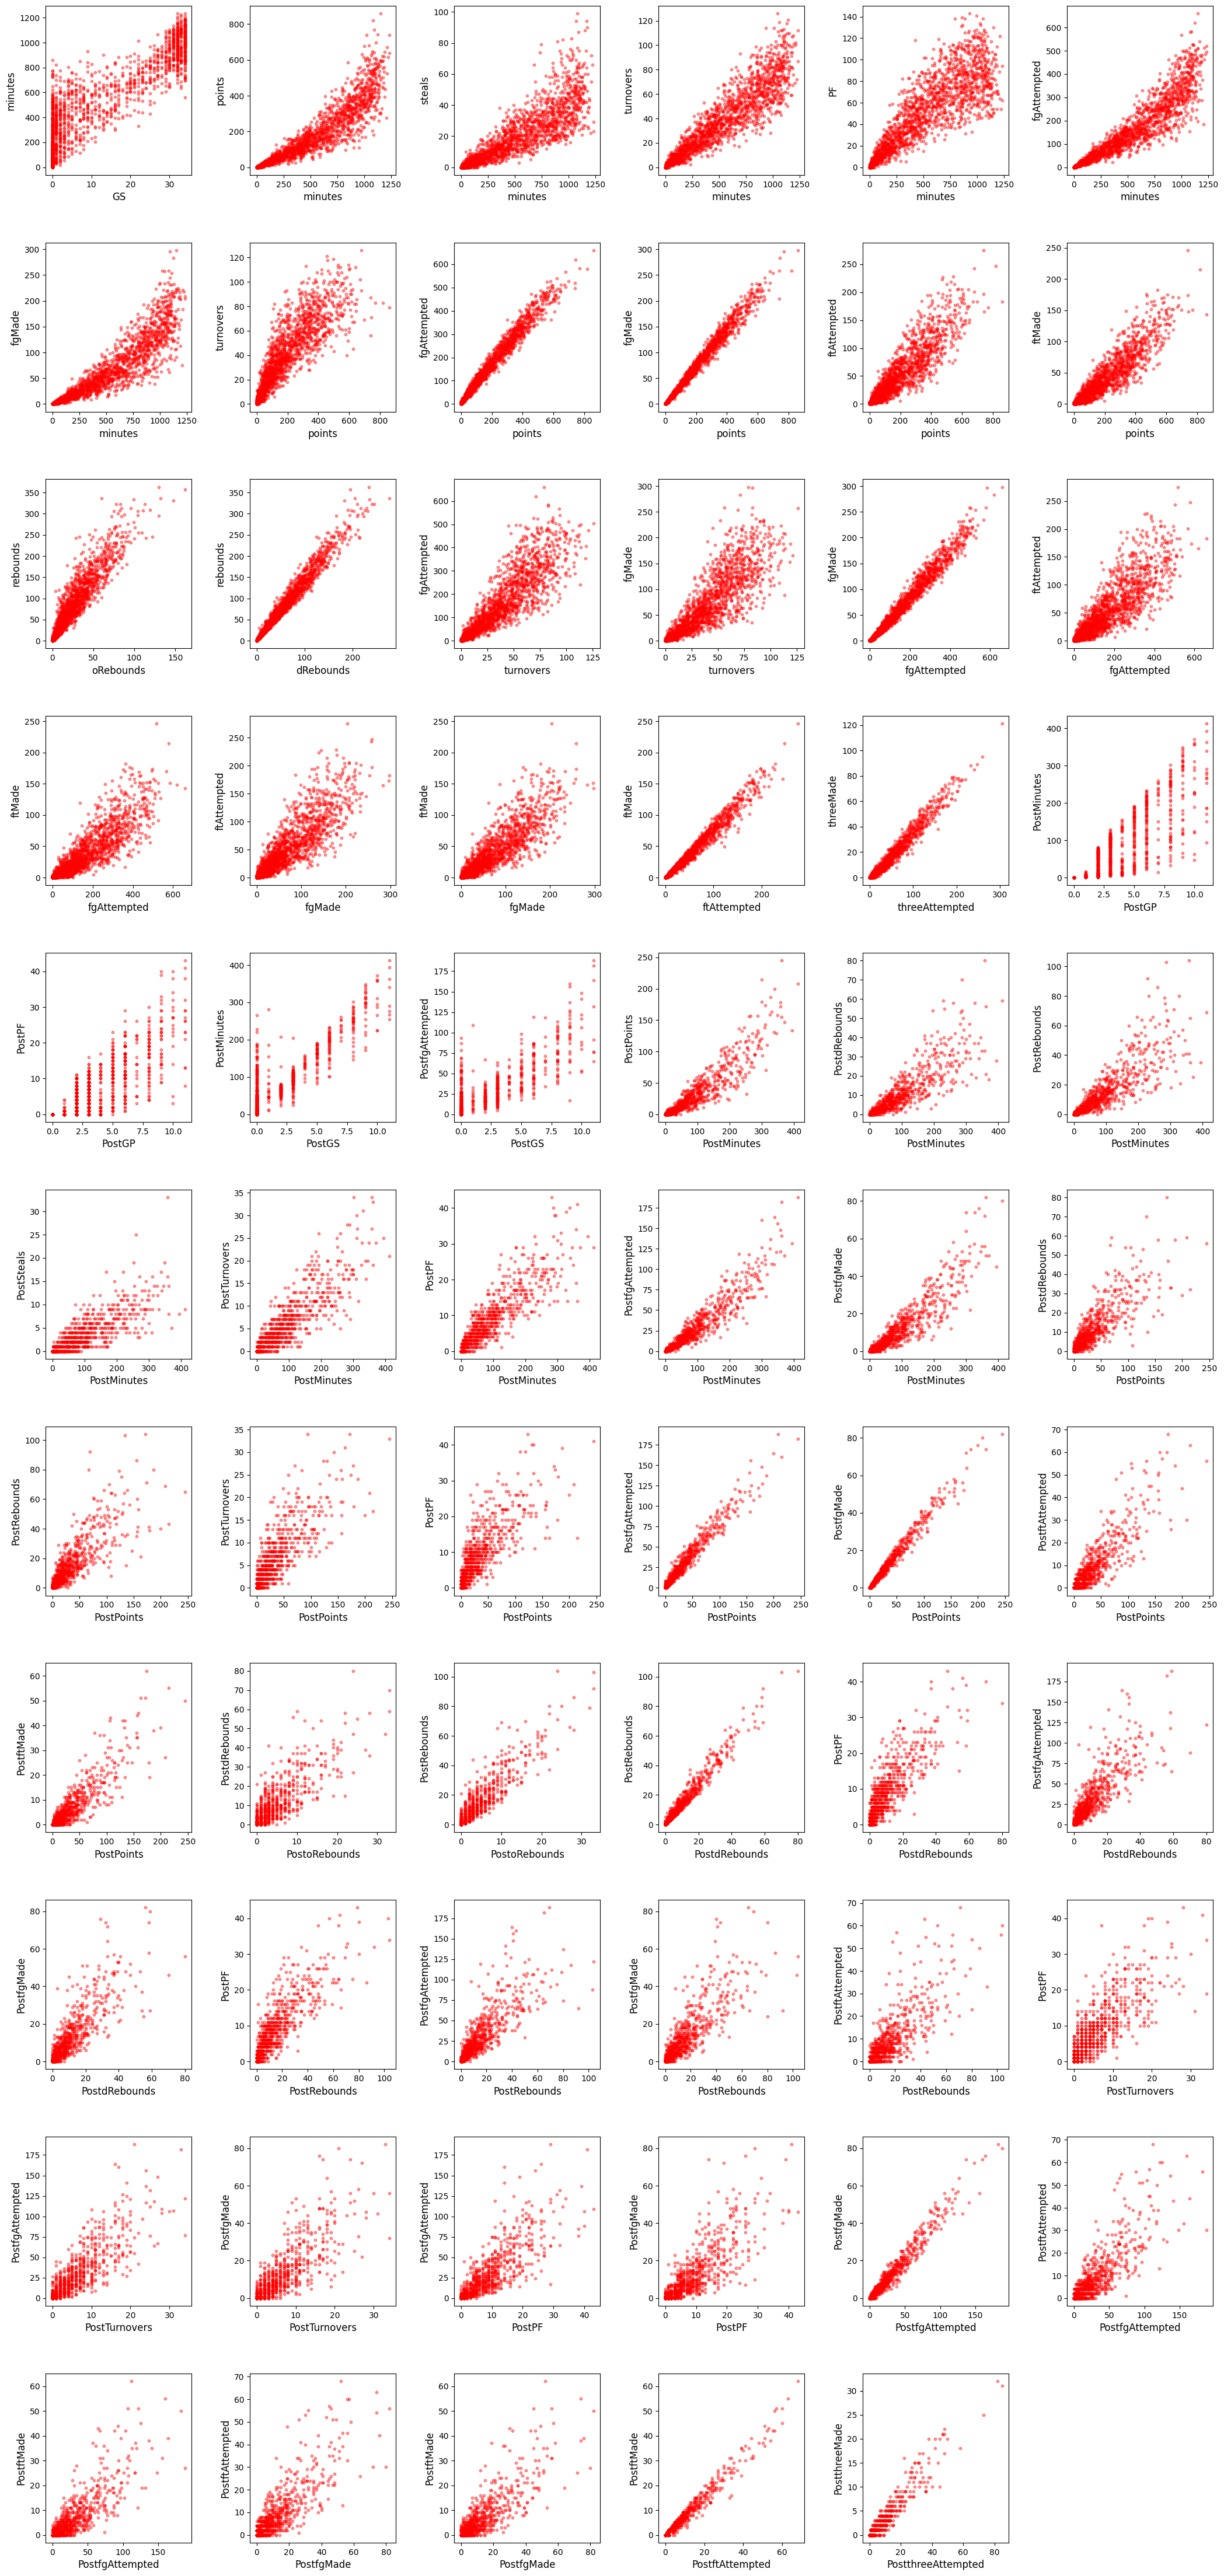

In [ ]:
check_correlations(players_teams)

Lets create some ratings to replace the original columns.

When the denominator is 0 we assumed, the result to also be 0

In [ ]:
players_teams['points_per_minute'] = players_teams['points']/players_teams['minutes']
del players_teams['points']
players_teams.loc[players_teams['minutes'] == 0, 'points_per_minute'] = 0

players_teams['steals_per_minute'] = players_teams['steals']/players_teams['minutes']
del players_teams['steals']
players_teams.loc[players_teams['minutes'] == 0, 'steals_per_minute'] = 0

players_teams['PF_per_minute'] = players_teams['PF']/players_teams['minutes']
del players_teams['PF']
players_teams.loc[players_teams['minutes'] == 0, 'PF_per_minute'] = 0

players_teams['turnovers_per_minute'] = players_teams['turnovers']/players_teams['minutes']
del players_teams['turnovers']
players_teams.loc[players_teams['minutes'] == 0, 'turnovers_per_minute'] = 0

players_teams['fgRate'] = players_teams['fgMade']/players_teams['fgAttempted']
players_teams.loc[players_teams['fgAttempted'] == 0, 'fgRate'] = 0
del players_teams['fgMade']
del players_teams['fgAttempted']

players_teams['ftRate'] = players_teams['ftMade']/players_teams['ftAttempted']
players_teams.loc[players_teams['ftAttempted'] == 0, 'ftRate'] = 0
del players_teams['ftMade']
del players_teams['ftAttempted']

players_teams['threeRate'] = players_teams['threeMade']/players_teams['threeAttempted']
players_teams.loc[players_teams['threeAttempted'] == 0, 'threeRate'] = 0
del players_teams['threeMade']
del players_teams['threeAttempted']

del players_teams['oRebounds']
del players_teams['dRebounds']

players_teams['PostfgRate'] = players_teams['PostfgMade']/players_teams['PostfgAttempted']
players_teams.loc[players_teams['PostfgAttempted'] == 0, 'PostfgRate'] = 0
del players_teams['PostfgMade']
del players_teams['PostfgAttempted']

players_teams['PostftRate'] = players_teams['PostftMade']/players_teams['PostftAttempted']
players_teams.loc[players_teams['PostftAttempted'] == 0, 'PostftRate'] = 0
del players_teams['PostftMade']
del players_teams['PostftAttempted']

players_teams['PostthreeRate'] = players_teams['PostthreeMade']/players_teams['PostthreeAttempted']
players_teams.loc[players_teams['PostthreeAttempted'] == 0, 'PostthreeRate'] = 0
del players_teams['PostthreeMade']
del players_teams['PostthreeAttempted']

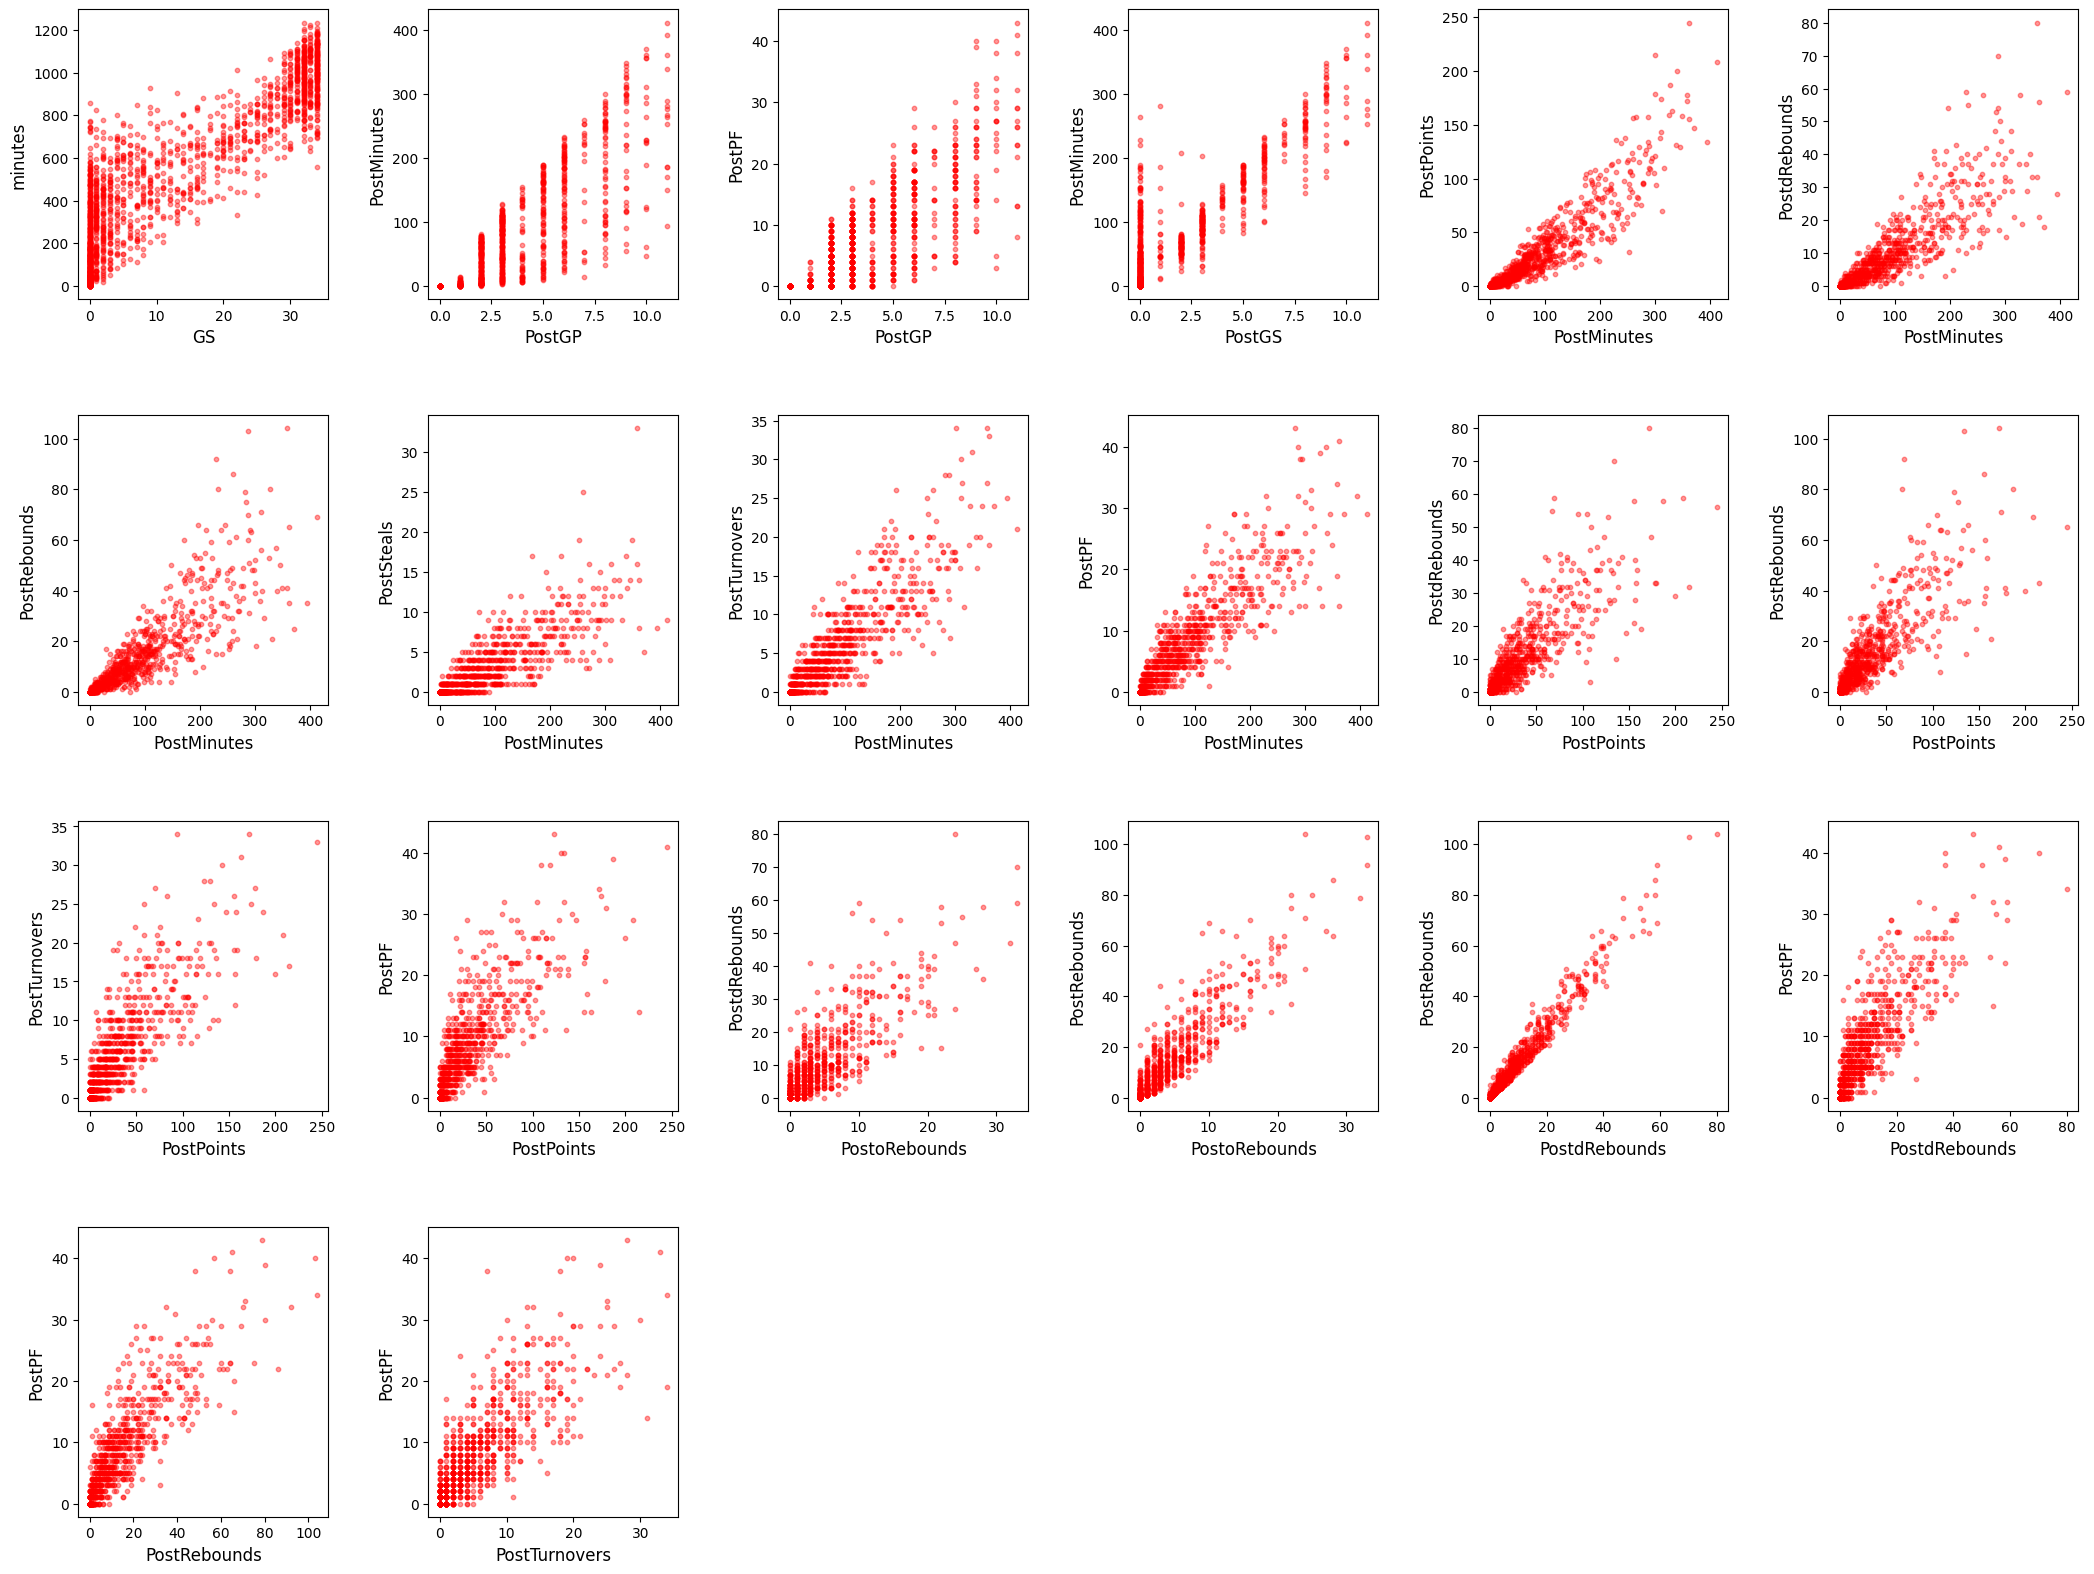

In [ ]:
check_correlations(players_teams)

In [ ]:
players_teams['PostPoints_per_minute'] = players_teams['PostPoints']/players_teams['PostMinutes']
players_teams.loc[players_teams['PostMinutes'] == 0, 'PostPoints_per_minute'] = 0
del players_teams['PostPoints']

players_teams['PostRebounds_per_minute'] = players_teams['PostRebounds']/players_teams['PostMinutes']
players_teams.loc[players_teams['PostMinutes'] == 0, 'PostRebounds_per_minute'] = 0
del players_teams['PostRebounds']

players_teams['PostSteals_per_minute'] = players_teams['PostSteals']/players_teams['PostMinutes']
players_teams.loc[players_teams['PostMinutes'] == 0, 'PostSteals_per_minute'] = 0
del players_teams['PostSteals']

players_teams['PostTurnovers_per_minute'] = players_teams['PostTurnovers']/players_teams['PostMinutes']
players_teams.loc[players_teams['PostMinutes'] == 0, 'PostTurnovers_per_minute'] = 0
del players_teams['PostTurnovers']

players_teams['PostPF_per_minute'] = players_teams['PostPF']/players_teams['PostMinutes']
players_teams.loc[players_teams['PostMinutes'] == 0, 'PostPF_per_minute'] = 0
del players_teams['PostPF']

del players_teams['PostdRebounds']
del players_teams['PostoRebounds']

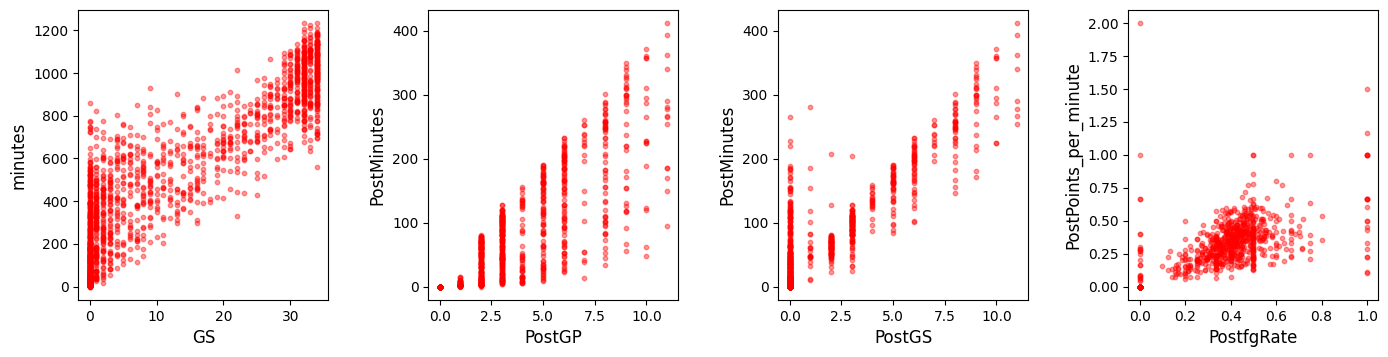

In [ ]:
check_correlations(players_teams)

In [ ]:
del players_teams['GS']
del players_teams['PostGS']

players_teams['minutes_per_game'] = players_teams['minutes']/players_teams['GP']
players_teams.loc[players_teams['GP'] == 0, 'minutes_per_game'] = 0
del players_teams['GP']
del players_teams['minutes']

players_teams['Postminutes_per_game'] = players_teams['PostMinutes']/players_teams['PostGP']
players_teams.loc[players_teams['PostGP'] == 0, 'Postminutes_per_game'] = 0
del players_teams['PostGP']
del players_teams['PostMinutes']

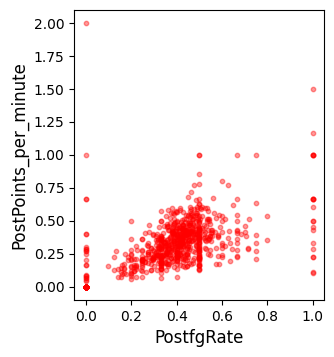

In [ ]:
check_correlations(players_teams)

Although we have two highly correlated features, 'PostPoints_per_minute' and 'PosrfgRate', they are both useful, so we will leave them as they are

Lets check for null values, again.

In [ ]:
players_without_11 = players_teams[players_teams['year'] < 11]

for col in players_teams.columns:
    if players_without_11[col].dtype in ['float64', 'int64']:
        na_num = players_without_11[col].isna().sum()
        if na_num > 0:
            print(f"Column '{col}' has {na_num} NaN values.")

So finally we will export the table players_teams as csv, so that other tables can use it.

In [ ]:
players_teams.to_csv("/content/drive/Shareddrives/ML 2024/tables/players_teams_cleaned.csv",index=False)